<center>
    <h1>Analysis of the ICFHR 2020 Competition on Image Retrieval for Historical Handwritten Fragments (HisFrag20) Dataset</h1>
    <hr>
    <br>
    <div style="margin:0 60px 0px 0">
        <img src="./../../readme-head.png" align=center width=500>
    </div>
    <h2>Data Understanding for solving a Jigsaw Puzzle of Historical Fragments</h2>
    <h3> by Timo Bohnstedt</h3>
    <br>
</center>


<a name='0'></a>

### Outline for this Notebook `(clickable)`

1. [Data Distribution](#1) <br>
1.1. [Are the IDs meaningful? If not, where can I get more meaningful data?](#1.1) <br>
1.2. [How many writers are there?](#1.2) <br>
1.3. [How many pages do the autohers have?](#1.3) <br>
1.4. [How many fragments are there per page?](#1.3) <br>
2. [Image Analysis](#2) <br>
2.1. [How large are the fragments?](#1.2) <br>
2.2. [How does the work of an writer look like?](#1.3.)<br>
2.3. [How does a page of a particular author look like?](#1.3.)<br>
2.4. [What does it look like when an image is gradually assembled (GIF)?](#1.3.)<br>
2.5. [Optional: Is there any further information, e.g. where the pictures come from?](#1.3.)<br>

## 0. Preparation of the Notebook

In [10]:
# import packages
from os import listdir, path
from os.path import isfile, join, splitext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

# TODO Change code completly to pathlib for crossfunctionality
from os import listdir, path
from PIL import Image
from pathlib import Path
from cv2 import imread, copyMakeBorder, imwrite, BORDER_CONSTANT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import get_info, set_size, get_filenames
from matplotlib.patches import Rectangle


import pandas as pd
from os import listdir
from os.path import isfile, join, splitext
from sklearn.model_selection import GroupShuffleSplit
import random
import csv

# prepare environtment
%matplotlib inline

# prepare plots
from helper_functions import set_size
sns.set(style="whitegrid")
plt.style.use('seaborn')
width = 496.85625

In [11]:
# declare global variables 
data_path = "/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/raw/hisfrag20"
data_path_test = "/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/raw/hisfrag20_test"

In [12]:
file_names = [splitext(f)[0] for f in listdir(data_path) if isfile(join(data_path, f))]
file_names_test = [splitext(f)[0] for f in listdir(data_path_test) if isfile(join(data_path_test, f))]

<a name='1'></a>

## 1. Data Distribution

<a name='1.1'></a>

### 1.1. Are the IDs meaningful? If not, where can I get more meaningful data?


The dataset contains a training and a test set with the following image naming-convention: 

```ruby
WID_PID_FID.jpg 

where 
WID = writer id
PID = page id, 
FID = fragment id.

```

The **train set** contains arround **100,000 fragments** using the Historical-IR19 as base dataset, they should all contain some text even some fragments are quite small. The **test set** contains about **20,000** new fragments

First, I will print the filename (label) to see wheather or not the label tells something meaninful

In [15]:
file_name = file_names[0]
file_name_test = file_names_test[0]

print(f'\033[1m\033[4mExample Filenames:\033[0m\033[0m\n{file_name = }\n{file_name_test = }\n')

file_names_parts = [i.split("_") for i in file_names]
file_names_test_parts = [i.split("_") for i in file_names_test]
df = pd.DataFrame.from_records(file_names_parts,columns=['writer_id', 'page_id','fragment_id'])
df_test = pd.DataFrame.from_records(file_names_test_parts,columns=['writer_id', 'page_id','fragment_id'])

Example Filenames:
file_name = '9121_4046_13'
file_name_test = '219_77800500_10553'



In [16]:
writers = df.nunique()[0]
writers_test = df_test.nunique()[0]
print(f'\033[1m\033[4mUnique Writers:\033[0m\033[0m\n{writers = }\n{writers_test = }\n')

pages_per_writer = df.groupby('writer_id')['page_id'].nunique()
mean = pages_per_writer.mean()
median = pages_per_writer.median()
mu = pages_per_writer.std()
max_pages = pages_per_writer.max()
min_pages = pages_per_writer.min()
print(f'\033[1m\033[4mPages per Writer:\033[0m\033[0m\n{mean = :.2f}\n{median = :.2f}\n{mu = :.2f}\n{max_pages = :.2f}\n{min_pages = :.2f}\n')

fragments_per_page = df.groupby('page_id')['fragment_id'].nunique()
mean = fragments_per_page.mean()
median = fragments_per_page.median()
mu = fragments_per_page.std()
max_pages = fragments_per_page.max()
min_pages = fragments_per_page.min()
print(f'\033[1m\033[4mFragments per Page:\033[0m\033[0m\n{mean = :.2f}\n{median = :.2f}\n{mu = :.2f}\n{max_pages = :.2f}\n{min_pages = :.2f}\n')

Unique Writers:
writers = 8717
writers_test = 1152

Pages per Writer:
mean = 1.98
median = 1.00
mu = 1.61
max_pages = 5.00
min_pages = 1.00

Fragments per Page:
mean = 5.91
median = 2.00
mu = 9.74
max_pages = 77.00
min_pages = 2.00



10470


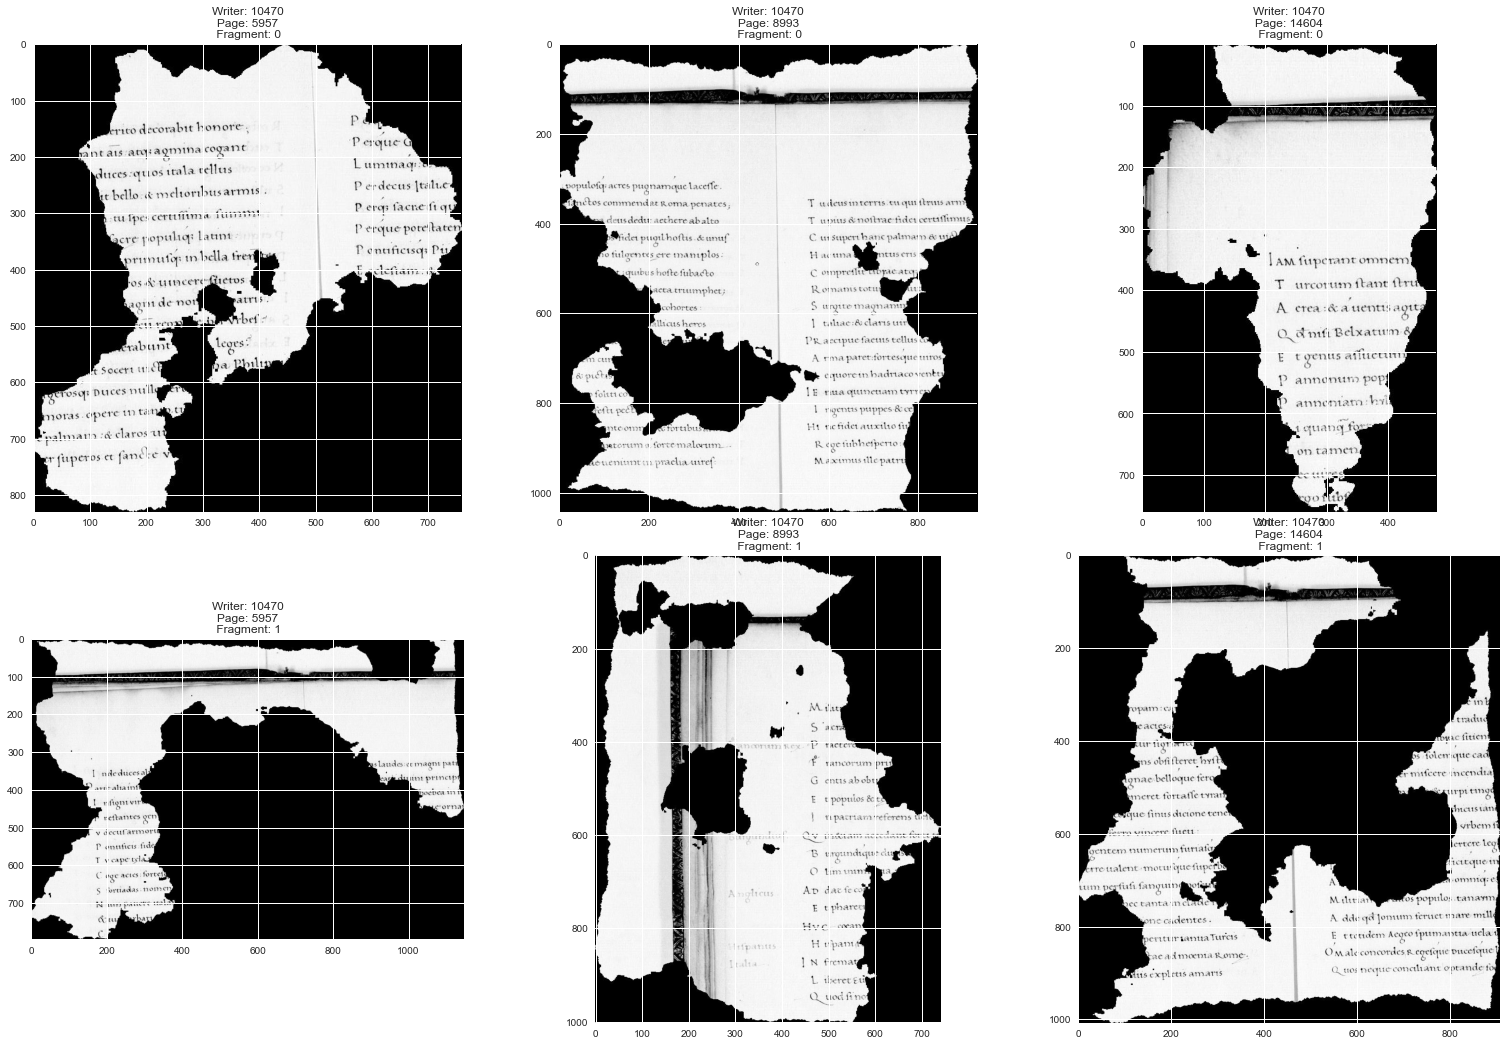

In [17]:
# get a random writer which has three pages
writers_w_three_pages = pages_per_writer[pages_per_writer ==3]
rand_writer = writers_w_three_pages.to_frame().sample().index[0]
print(rand_writer)

# get df with writers work items
writer_df = df[df['writer_id'] == rand_writer]
writer_df = writer_df.astype(int)
writer_df = writer_df.sort_values(['page_id','fragment_id'])

# drop writer coll because it it not neccesary
writer_df = writer_df.drop(['writer_id'], axis=1)

# drop writer and add a col for coll id (row id = fragment_id)
_,idx = np.unique(writer_df['page_id'],return_inverse=True) 
writer_df['col_id'] = idx
writer_df['row_id'] = df['fragment_id']
writer_df = writer_df.set_index(['col_id','row_id'])

# get value of nrows by the number of fragments
nrows = writer_df['fragment_id'].max() +1

ncols = 3  # array of sub-plots
figsize = [21, nrows * 7]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.tight_layout(pad=0.4, w_pad=5, h_pad=2)

for i, axi in enumerate(ax.flat):
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    current_row = writer_df.query("col_id == {} and row_id == '{}'".format(colid,rowid))
    try:
        current_page = current_row['page_id'].astype(str).values[0]
        current_fragment = current_row['fragment_id'].astype(str).values[0]
        filename = data_path +'/' + rand_writer + '_' + current_page + '_' + current_fragment + '.jpg'
        img = Image.open(filename)    
        axi.imshow(img)
        # write row/col indices as axes' title for identification
        axi.set_title('Writer: {}\nPage: {}\n Fragment: {}'.format(rand_writer,current_page,current_fragment))
    except:
        axi.set_visible(False)
        
plt.show()

fig.savefig('./figures/readme-writer-sample.svg', format='svg', bbox_inches='tight')

AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

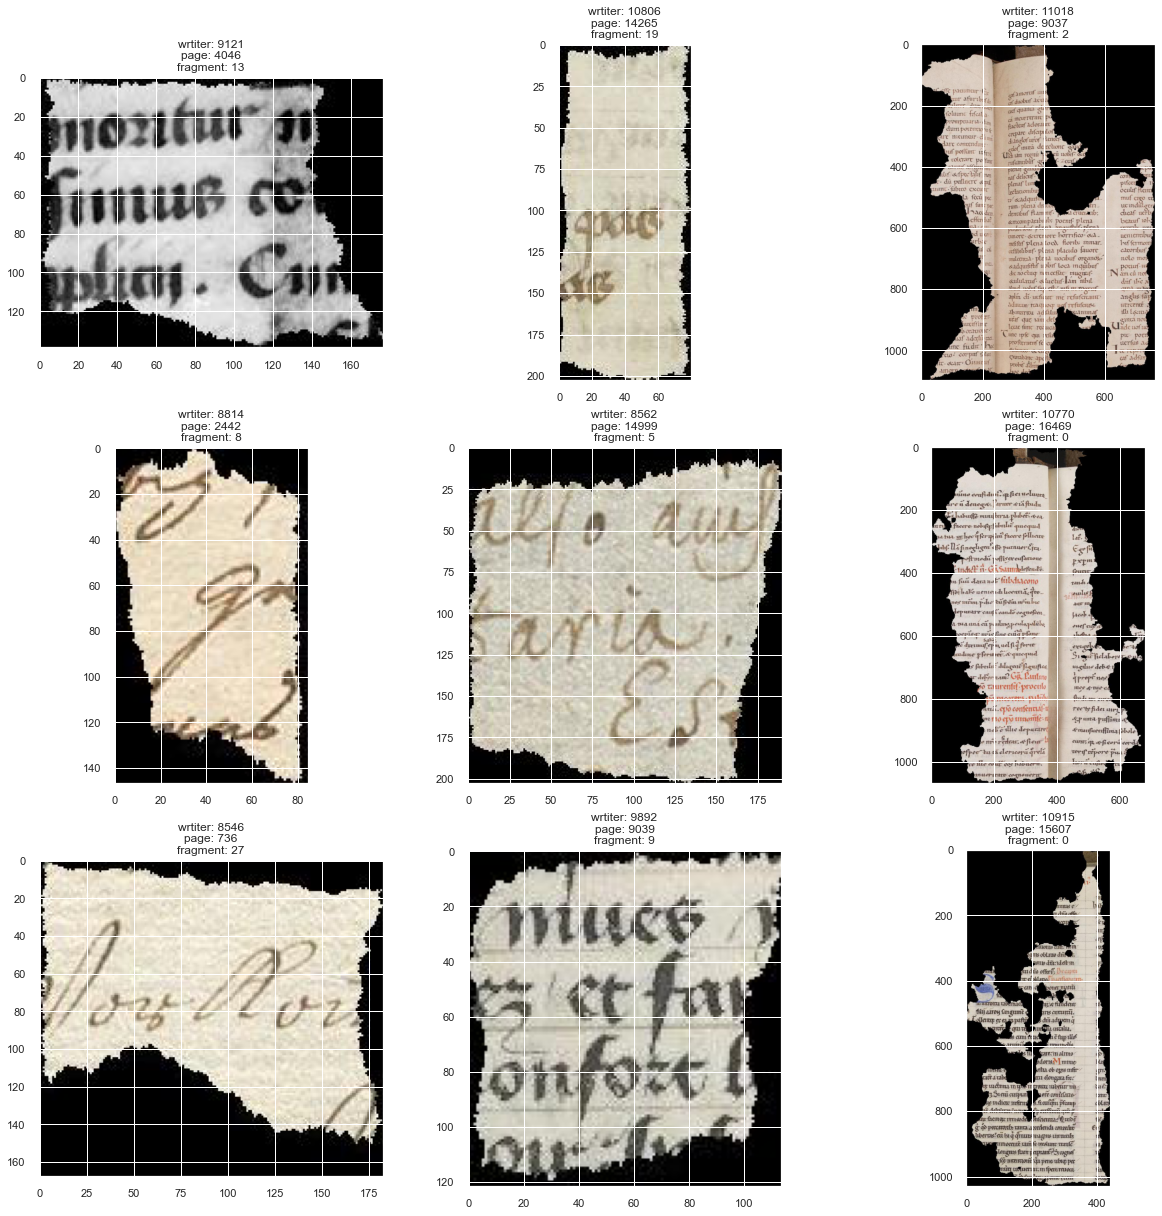

In [30]:
fig = plt.figure(figsize=(21, 21))
fig.tight_layout(pad=0.4, w_pad=5, h_pad=2)
columns = 3
rows = 3

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    # define filename
    filename = data_path +'/' + file_names[i] + '.jpg'
    img = Image.open(filename)
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # set title
    ax[-1].set_title('wrtiter: '+file_names_parts[i][0] +'\n' + 'page: '+file_names_parts[i][1] + '\n' + 
    'fragment: '+file_names_parts[i][2])  
    #plot the img
    plt.imshow(img)

plt.show()  # finally, render the plot
fig.savefig('./figures/readme-writers-samples.svg', format='svg', bbox_inches='tight')

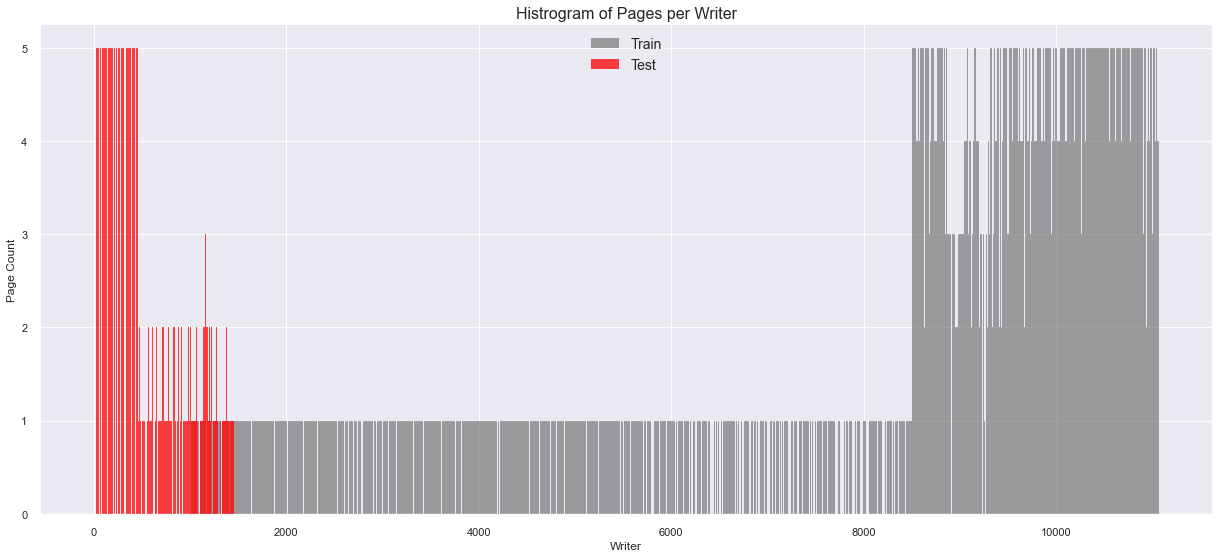

In [19]:
# Clean up the df so that each page has only one entry in order to visualize how many pages come from a unqiue author.
df_temp = df.copy()
df_test_temp = df_test.copy()
df_test_temp.drop_duplicates(subset=['page_id'],inplace=True)
df_temp.drop_duplicates(subset=['page_id'],inplace=True)
df_temp = df_temp.astype(int)
df_test_temp = df_test_temp.astype(int)

sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(21, 9))
sns.despine(f)

sns.histplot(
    df_temp,
    stat='count',
    x="writer_id",
    palette="light:m_r",
    kde=False,
    label='Train',
    color='gray',
    discrete=True,
)

sns.histplot(
    df_test_temp,
    stat='count',
    x="writer_id",
    palette="light:m_r",
    kde=False,
    label='Test',
    color='red',
    discrete=True,
)


plt.legend(prop={'size': 14})
plt.title('Histrogram of Pages per Writer',size=16)
plt.xlabel('Writer')
plt.ylabel('Page Count')
plt.show()
f.savefig('./figures/distribution.svg', format='svg', bbox_inches='tight')

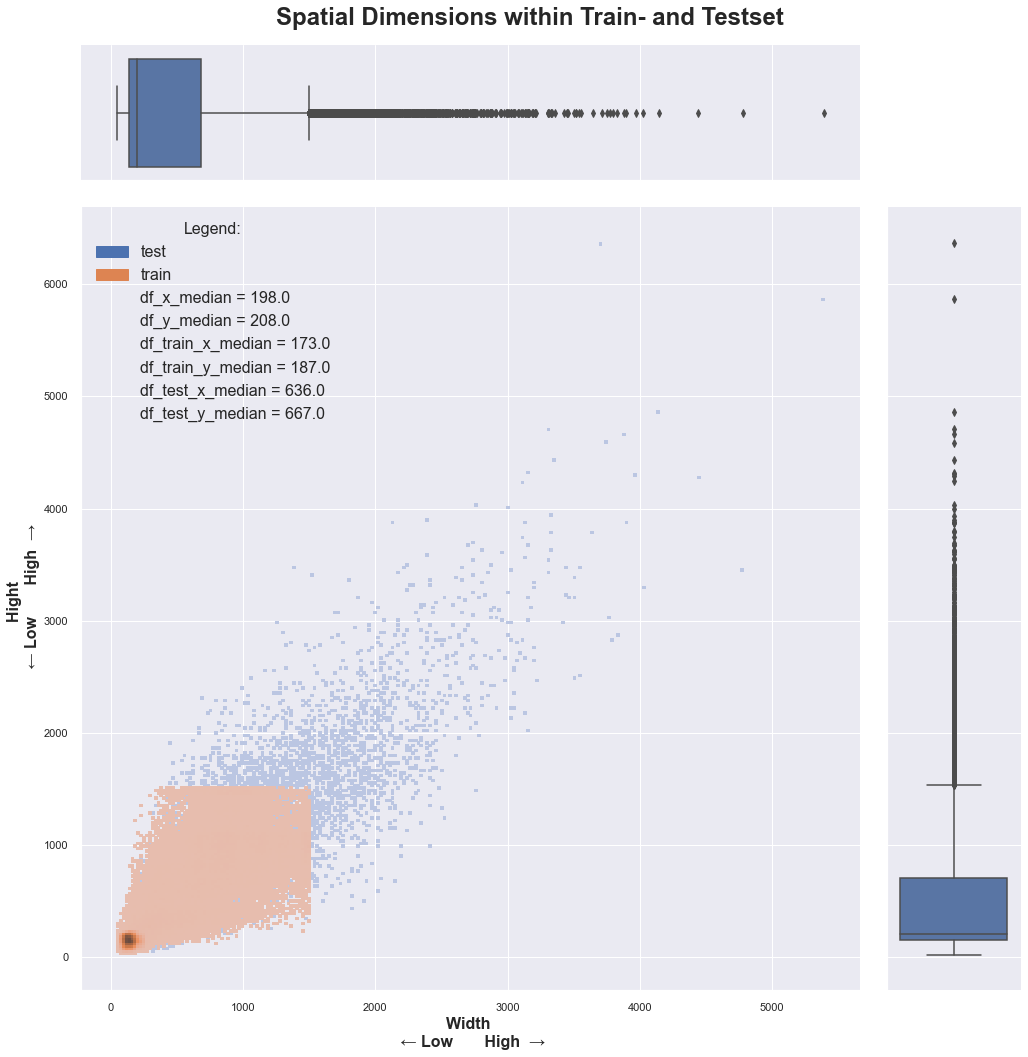

In [28]:
train_filenames, test_filenames = get_filenames(data_path, data_path_test)
train_size, test_size = get_imgsize(train_filenames, test_filenames, data_path, data_path_test)
train_size = np.array(train_size)
test_size = np.array(test_size)
train_df = pd.DataFrame(train_size, columns=['x','y'])
test_df = pd.DataFrame(test_size, columns=['x','y'])
train_df['Dataset'] = 'train'
test_df['Dataset'] = 'test'
df = pd.concat([test_df, train_df])
df_x_median = df.x.median()
df_y_median = df.y.median()
df_train_x_median = train_df.x.median()
df_train_y_median = train_df.y.median()
df_test_x_median = test_df.x.median()
df_test_y_median = test_df.y.median()
g = sns.JointGrid(data=df, x="x", y="y", hue='Dataset',height=14)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)
g.ax_joint.set_xlabel('Width \n ← Low       High  →', fontweight='bold', size=16)
g.ax_joint.set_ylabel('Hight \n ← Low       High  →', fontweight='bold', size=16)
g.fig.suptitle('Spatial Dimensions within Train- and Testset',y=1.025,fontweight='bold', size=24)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.ax_joint.get_legend()
    handles = old_legend.legendHandles
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=1)
    handles.append(extra)
    handles.append(extra)
    handles.append(extra)
    handles.append(extra)
    handles.append(extra)
    handles.append(extra)
    labels = [t.get_text() for t in old_legend.get_texts()]
    labels.append(f'{df_x_median = }')
    labels.append(f'{df_y_median = }')
    labels.append(f'{df_train_x_median = }')
    labels.append(f'{df_train_y_median = }')
    labels.append(f'{df_test_x_median = }')
    labels.append(f'{df_test_y_median = }')
    title = old_legend.get_title().get_text()
    ax.ax_joint.legend(handles, labels, loc=new_loc, title='Legend:', **kws)
    
move_legend(g, "upper left", fontsize=16, title_fontsize=16)
plt.show()

## Pixel Analysis for normalization

In [42]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import cv2
from albumentations.pytorch import ToTensorV2
from os import listdir
from tqdm import tqdm
from os.path import isfile, join, splitext

device = torch.device('cpu')
num_workers = 2
image_size = 200
batch_size = 8


class LeafData(Dataset):
    """
    PyTorch Dataset Class which gets data from a csv file
    which was initialized within the processing step (./notebooks/DataPreparation_V2.ipynb)
    """

    def __init__(self, csv_file, raw_img_path, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.raw_img_path = raw_img_path

    def __getitem__(self, index):
        sample = self.df.loc[index]

        image =  cv2.imread(self.raw_img_path + sample['0'] + '.jpg', cv2.COLOR_BGR2RGB)




        if self.transform:
            img_0 =  self.transform(image = image)['image']

        return img_0

    def __len__(self):
        length = self.df.shape[0]
        return length


augs = A.Compose([A.Resize(height=image_size,
                           width=image_size),
                  A.Normalize(mean=(0, 0, 0),
                              std=(1, 1, 1)),
                  ToTensorV2()])

image_dataset = LeafData(
    csv_file='/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/prepared/paris_as_csv/dev_train.csv',
    raw_img_path='/Users/beantown/PycharmProjects/jigsaw-puzzle-solver',
    transform=augs)

# data loader
image_loader = DataLoader(image_dataset,
                          batch_size=batch_size,
                          shuffle=False)

####### COMPUTE MEAN / STD

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis=[0, 2, 3])

####### FINAL CALCULATIONS

# pixel count
data_path = "/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/raw/hisfrag20"
data_path_test = "/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/raw/hisfrag20_test"

file_names = [splitext(f)[0] for f in listdir(data_path) if isfile(join(data_path, f))]

df = pd.DataFrame(file_names)

count = len(df) * image_size * image_size

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)

# output
print('mean: ' + str(total_mean))
print('std:  ' + str(total_std))

## Split Data, Makes Labels & Pairs

In [ ]:
result_path = '/Users/beantown/PycharmProjects/jigsaw-puzzle-solver/data/hisfrag20/prepared/paris_as_csv/'

In [ ]:
df = get_info(data_path=data_path)

In [ ]:
gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
train_idx, val_idx = next(gs.split(df, groups=df.ID_of_original_papyrus))

In [ ]:
train = df.loc[train_idx]
val = df.loc[val_idx]

In [ ]:
train.ID_of_original_papyrus.isin(val.ID_of_original_papyrus).any()
test = get_info(data_path=data_path_test)

In [ ]:
train.ID_of_original_papyrus.isin(test.ID_of_original_papyrus).any()
val.ID_of_original_papyrus.isin(test.ID_of_original_papyrus).any()

In [ ]:
def sample_pairs(K, data, IDList):
    """
    used from: https://github.com/plnicolas/master-thesis/blob/master/Papy-S-Net/PairGenerator.py
    Function to create fragment pairs given a Pandas DataFrame and a list of IDs.
    Parameters:
    ----------
        - K: The number of pairs of each type (positive and negative) to sample. Duplicates will be dropped,
        so the final number of pairs WILL be smaller than 2K
        - Data: Pandas DataFrame with rows of the form [path_to_fragment_image, ID_of_original_papyrus]
        - IDList: List containing the IDs of the papyri to sample fragments from
    Returns:
    --------
        - pairs: A list of fragment pairs, of the form [path_to_frag1, path_to_frag2]
        - labels: A list of labels, i.e. original papyrus IDs
    """

    pairs = []
    labels = []

    # For each papyrus used for training
    for index in IDList:
        isIndex = data.iloc[:, 1] == index
        isNotIndex = data.iloc[:, 1] != index
        # List of images from the indexed papyrus
        indexTrueList = data[isIndex].iloc[:, 0]
        # List of images NOT from the indexed papyrus
        indexFalseList = data[isNotIndex].iloc[:, 0]

        # K negative pairs
        p1List = indexTrueList.sample(n=K, replace=True, random_state=356)
        p2List = indexFalseList.sample(n=K, replace=True, random_state=323)
        for k in range(K):
            pair = [p1List.values[k], p2List.values[k]]
            if pair not in pairs:
                pairs.append(pair)
                labels.append(1)

        # K positive pairs
        p1List = indexTrueList.sample(n=K, replace=True, random_state=362)
        p2List = indexTrueList.sample(n=K, replace=True, random_state=316)
        for k in range(K):
            pair = [p1List.values[k], p2List.values[k]]
            if pair not in pairs:
                pairs.append(pair)
                labels.append(0)

    # Shuffle the pairs and label lists before returning them
    # The two lists are shuffled at once with the same order, of course
    tmp = list(zip(pairs, labels))
    random.shuffle(tmp)
    pairs, labels = zip(*tmp)

    return pairs, labels

In [ ]:
X_train, y_train = sample_pairs(K=2, data=train, IDList=train.ID_of_original_papyrus.unique())
X_val, y_val = sample_pairs(K=2, data=val, IDList=val.ID_of_original_papyrus.unique())
X_test, y_test = sample_pairs(K=2, data=test, IDList=test.ID_of_original_papyrus.unique())

train = pd.DataFrame(X_train)
train['y'] = y_train
#train.to_csv(result_path + 'train.csv', index=False)

val = pd.DataFrame(X_val)
val['y'] = y_val
#val.to_csv(result_path + 'val.csv', index=False)

test = pd.DataFrame(X_test)
test['y'] = y_test
#test.to_csv(result_path + 'test.csv', index=False)